In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRicJhfB4KqN803y8BnApB987GWGRohnqnfu3U08IT7ahFeQgx8mHIoQNQ1CTbTLlcXDCSF_24Fw9Jl/pub?gid=89785152&single=true&output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

* Null Hypothesis: There is no difference between insurance charges for people who smoke and those who do not smoke. 
* Alternative Hypothesis:There are higher insurance charges for people that smoke than those who do not smoke. 

* Select the correct test according to the data type and number of samples: 2 sample T-Tests

In [3]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [5]:
smoker_charge = df.loc[df['smoker']=='yes', "charges"].copy()
no_smoker_charge = df.loc[df['smoker']=='no', "charges"].copy()

In [6]:
zscores_smoker = stats.zscore(smoker_charge)
outliers_smoker = abs(zscores_smoker)>3
np.sum(outliers_smoker)

0

In [7]:
zscores_no_smoker = stats.zscore(no_smoker_charge)
outliers_no_smoker = abs(zscores_no_smoker)>3
np.sum(outliers_no_smoker)

24

In [8]:
# remove outliers from female group
no_smoker_charge = no_smoker_charge[(np.abs(stats.zscore(no_smoker_charge)) < 3)]

In [9]:
# test the male group for normality
norm_result_smoker = stats.normaltest(smoker_charge)
norm_result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [10]:
# test the male group for normality
norm_result_no_smoker = stats.normaltest(no_smoker_charge)
norm_result_no_smoker

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [11]:
# Test for equal variance
variance_result = stats.levene(smoker_charge, no_smoker_charge)
variance_result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

In [12]:
# Independent t-test with equal_var set to False
ttest_result = stats.ttest_ind(smoker_charge, smoker_charge, equal_var = False)
ttest_result

Ttest_indResult(statistic=0.0, pvalue=1.0)

* The T-Test pvalue is < 0.05, so we reject the null hypothesis and accept that there is a significant difference between the charges for people who smoke and those who do not smoke. 

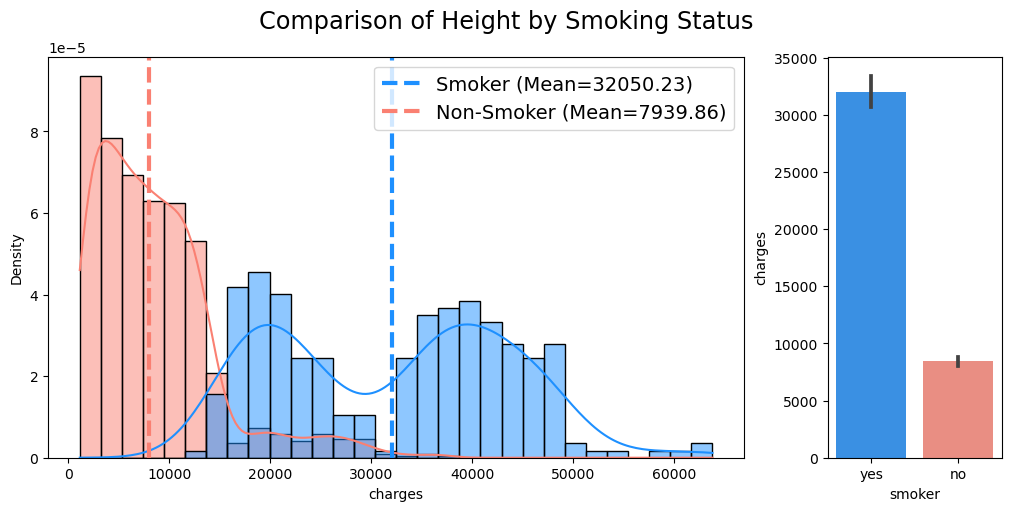

In [13]:
smoker_palette={'yes':'dodgerblue', "no":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=smoker_palette)

ax.axvline(np.mean(smoker_charge), ls='--',lw=3, 
           label=f"Smoker (Mean={np.mean(smoker_charge):.2f})",color=smoker_palette['yes'])

ax.axvline(np.mean(no_smoker_charge), ls='--', lw=3, 
           label=f"Non-Smoker (Mean={np.mean(no_smoker_charge):.2f})",color=smoker_palette['no'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=smoker_palette)
fig.suptitle('Comparison of Height by Smoking Status',fontsize='xx-large');

# Q2: Are men more likely to smoke than women?

* Null Hypothesis: There is no relationship between sex and if someone smokes
* Alternative Hypothesis: A person's sex influences whether or not a person smokes. 

* Select the correct test according to the data type and number of samples: Chi-Square

In [14]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [15]:
smoke_table = pd.crosstab(df['sex'], df['smoker'])
smoke_table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
# Run the Test and Save the Output
smoke_result = stats.chi2_contingency(smoke_table)
chi2, p, deg_free, expected_vals = smoke_result #this labels the results

In [17]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

* The p-value is less than 0.05 in our chi-square test, we reject the null hypothesis. There is a relationship between a person's sex and whether or not they smoke. 

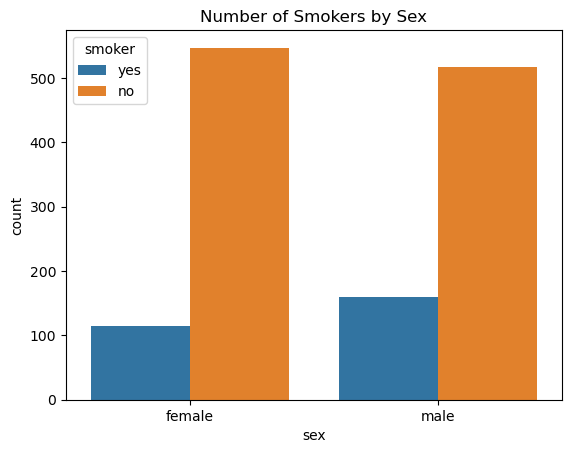

In [18]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

# Q3. Do different regions have different charges, on average?

* Null Hypothesis: Different regions all have the same charges on average. 
* Alternative Hypothesis: Different regions have different charges. 

* Select the correct test according to the data type and number of samples: ANOVA

In [19]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [20]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
regions = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    regions[i] = data
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [21]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in regions.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [22]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


* The data is not normally distributed, but since we have a large enough sample we can ignore this assumption. We will continue with the ANOVA test. 

In [23]:
# with the * operator 
stats.levene(*regions.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

* The pvalue is less than 0.05 so we fail to reject the null hypothesis. 

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

In [25]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


* We do not completely fail the hypothesis test. We see that there is on significant results from the table above. We see that there is a difference in charge between the southeast and southwest regions. The other regions when compared with each other, we do not reject the null hypothesis. 

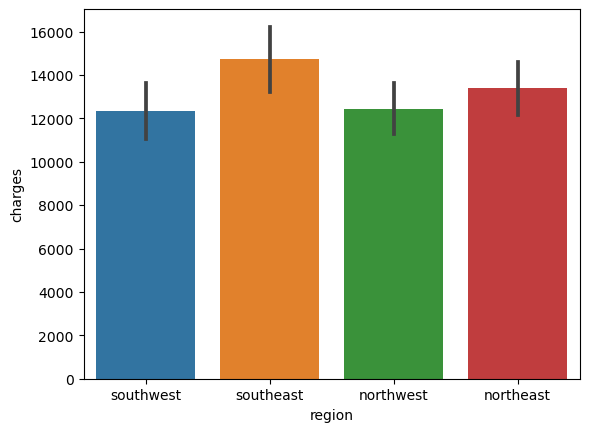

In [26]:
sns.barplot(data=df, x='region',y='charges');